In [1]:
import keras

In [2]:
import tensorflow as tf

In [3]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [4]:
keras.__version__

'2.15.0'

In [5]:
tf.__version__

'2.15.0'

In [6]:
from keras.datasets import mnist

In [18]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

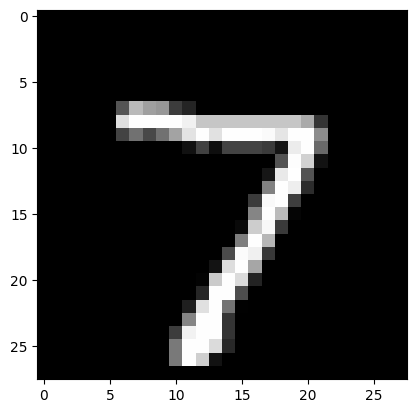

In [26]:
sample = 0
image = X_test[sample]
plt.figure()
plt.imshow(image, cmap='gray')
plt.show()

In [27]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

In [45]:
#Given input of noise (latent) vector, the Generator produces an image.
def build_generator():
  noise_shape = (100,) #1D array of size 100(latent vector / noise)

  #Define your generator network
  #Here we are only using Dense Layers. But network can be complicated nased
  #on the application. For example, you can use VGG for super res. GAN.

  model = Sequential()

  model.add(Dense(256, input_shape=noise_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(1024))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(np.prod(img_shape), activation='tanh'))
  model.add(Reshape(img_shape))

  model.summary()

  noise = Input(shape=noise_shape)
  img = model(noise)  #Generated image

  return Model(noise, img)

#Alpha-a is a hyperparameter which controls the underlying value to which the
#function saturates negatives network inputs.
#Momentum - Speed up the training

In [46]:
#Given an input image, the Discriminator outputs the likelihood of the image being real.
 #Binary classificartion - true or false (we're calling it validity)
def build_discriminator():

  model = Sequential()
  model.add(Flatten(input_shape=img_shape))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()

  img = Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

In [48]:
#Now that we have constructed our two models it's time to pit them against each other.
#We do this by defining a training function, Loading the data set, re-scaling our training
#images and setting the ground truths.
def train(epochs, batch_size=128, sample_interval=500):
  #Load the dataset
  (X_train, _), (_, _) = mnist.load_data()

  #Convert to float and Rescale -1 to 1 (Can also 0 to 1)
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5

  #Add channels dimension. As the input to our gen and discr. has a shape 28x28x1
  X_train = np.expand_dims(X_train, axis=3)

  half_batch = int(batch_size / 2)

#We then loop through a number of epochs to train our Disc by first selecting
#a random batch of images from our true dataset, generating a set of images our
#Generator, feeding both set of images into our Disc, and finally setting the
#loss parameters for both the real and fake images, as well as the combined loss.
  for epoch in range(epochs):
    #Train Discriminator

    #Select a random half batch of real images
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]
    noise = np.random.normal(0, 1, (half_batch, 100))

    #Generate a random half batch of real images
    gen_imgs = generator.predict(noise)

    #Train the disc on real and fake images, seperately
    #Research showed that seperate training is more effective.
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

    #Take average Loss from real and fake images.
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

#And within the same loop we train our Generator, by setting the input noise and
#ulitamately training the Generator to have the Disc. label its samples as valid
#by specifying the gradient loss.

  #Train Generator

#Create noise vectors as input for generator.
#Create as many noise vector as defined by the batch size.
#Based on normal distribution. Output will be of size (batch size, 100)
    noise = np.random.normal(0, 1, (batch_size, 100))

    #The generator wants the disc. to label the generated samples
    #as valid(ones)
    #This is where the generator is trying to trick disc. into believing
    #the generated image is true (hence value of 1 for y)
    valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size

    #Generator is part of combined where it got directly linked with the disc.
    #Train the generator with noise as x and 1 as y.
    #Again, 1 as the output as it is adversarial and if generator did a great
    #job of folling the disc. then the output would be 1(true)
    g_loss = combined.train_on_batch(noise, valid_y)

#Additionally, in order for use to keep track of our training process, we print the
#progress and save the sample image output depending on the epoch interval specified.
#Plot the progress
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    #If at save interval => save generated image samples
    if epoch % sample_interval == 0:
      save_imgs(epoch)

#when the specific sample_interval is hit, we call the
#sample_image function. Which looks as follows.

def save_imgs(epoch):
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r * c, 100))
  gen_imgs = generator.predict(noise)

  #Rescale images 0-1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
      axs[i,j].axis('off')
      cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()
#This function saves our images for us to view

##############################################################
#Let us also define our optimizer for easy use letter on.
#That way if you change your mind, you can change it easily here
optimizer = Adam(0.0002, 0.5) #Learning rate and momentum

#Build and compile the disc. first.
#Generator will be trained as part of the combined model, later.
#pick the loss function and the type of metric to keep track.
#Binary cross entropy as we are doing prediction and it is a better
#loss function compared to MSE or other.
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

#build nd compile our Disc, pick the loss function

#Since we are only generating(faking) images, let us nor track any metrics.
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

#This builds the Generator and defines the input noise.
#In a GAN the Generator network takes noise z as an input to produce its images.
z = Input(shape=(100,))
img = generator(z)
